In [3]:
# 书第82页
import numpy as np
import matplotlib.pyplot as plt
from utils.GridWorld import GridWorld
from utils.AgentBasics import Agent, Policy

## 定义有用的函数和grid world

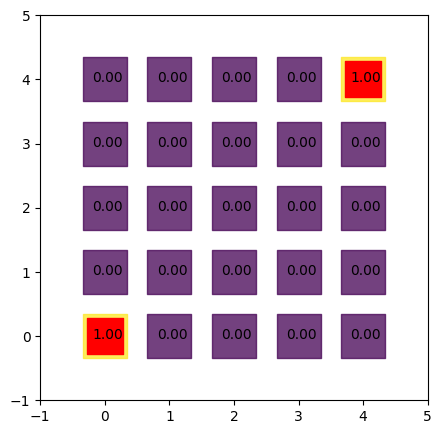

In [4]:
world_size = 5
# Show grid world with two terminal states
grid_world_1 = GridWorld(world_size, terminal_states=[(0, 0), (world_size-1, world_size-1)])
grid_world_1.render()

## Value Iteration
Policy Iteration中的Policy Evaluation很占时间，也很麻烦，但是实际上，我们可以不必强行追求它收敛，因为从上一节的例子中可以看到，经过三四次循环，其数值已经差不多可以用来衡量很多state的state-value了。<p>
Policy Iteration的过程是：使用policy衡量state-value -> 使用action-value矫正policy -> 使用policy衡量state-value -> 使用action-value矫正policy，如此往复。也就是state-value取决于policy，policy取决于action-value，而action-value又取决于state-value。那么为啥不直接用action-value不断地矫正state-value，这样就可以跳过"使用policy衡量state-value"，即policy evaluation。<p>
因此我们可以有如下公式
$$v_{k+1}(s)=\underset{a}{max}\sum_{s',r} p(s',r|s,a)(r+\gamma \cdot v_k(s'))$$
公式中max后面的部分为采取了action后得到的期待回报，即action-value。我们直接选取了回报最大的action作为这个state的state-value。由于action-value和state-value是循环依赖的(看action-value公式的最后一项$v_k(s')$就是下一个state的state-value)，每更新一次state-value，所有state上所有action的action-value也会跟着变。循环直至收敛，最终每个state的state-value就是这个state对应的最好的action-value，这个最好的action-value对应的action就是最终的policy！！
$$\pi(s)=\underset{a}{argmax}\sum_{s',r}p(s',r|s,a)(r+\gamma \cdot v(s'))$$

NOTE: getModelNextStateProbs(state, action) assumes a model exists for the environment.


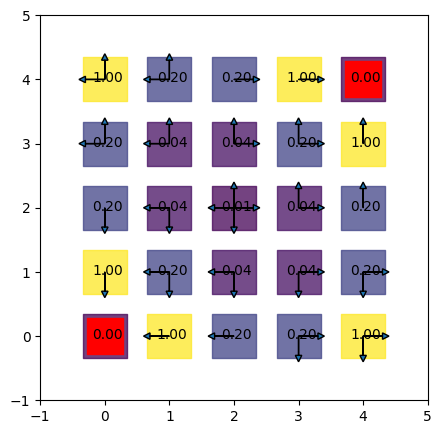

In [5]:
def valueIteration(grid_world: GridWorld, figsize=None):
    # This is our toy policy, all actions for all states are initialized to the same chance
    # We have a policy for each state
    agent = Agent(grid_world, Policy(grid_world))
    agent.initTerminalValues(grid_world)

    threshold = 0.001
    update_amount = 100
    gamma = 0.2

    # STEP 1. Value Iteration
    while update_amount >= threshold:
        new_state_values = np.zeros_like(agent.state_value)
        # iterate over all states
        for sid in grid_world.getNonTerminalStateIds():

            # Iterate all actions for the current state
            # new state value is the maximum of all action values
            for aid in grid_world.getValidActionIds(sid):
                next_state_id = np.where(grid_world.getModelNextStateProbs(sid, aid) == 1)[0][0]
                agent.action_value[sid, aid] = grid_world.getReward(next_state_id) + gamma * agent.state_value[next_state_id]
            new_state_values[sid] =  np.max(agent.action_value[sid, :])

        update_amount = np.sum(np.abs(new_state_values - agent.state_value))
        agent.state_value = new_state_values

    # STEP 2. Policy Improvement
    # iterate over all states
    for sid in grid_world.getNonTerminalStateIds():
        agent.policy.makeGreedyTo(agent.action_value, sid)

    agent.policy.normalize()

    grid_world.render(agent, figsize)
    plt.show()

valueIteration(grid_world_1)

仍然是很棒的图，但是其state-value明显和Policy Iteration的结果不同，这是因为他们state-value计算方式有区别，但重要的是两者的最终policy是一样的，只要policy一样，两个agent在同样state就能做出一样的选择。

NOTE: getModelNextStateProbs(state, action) assumes a model exists for the environment.


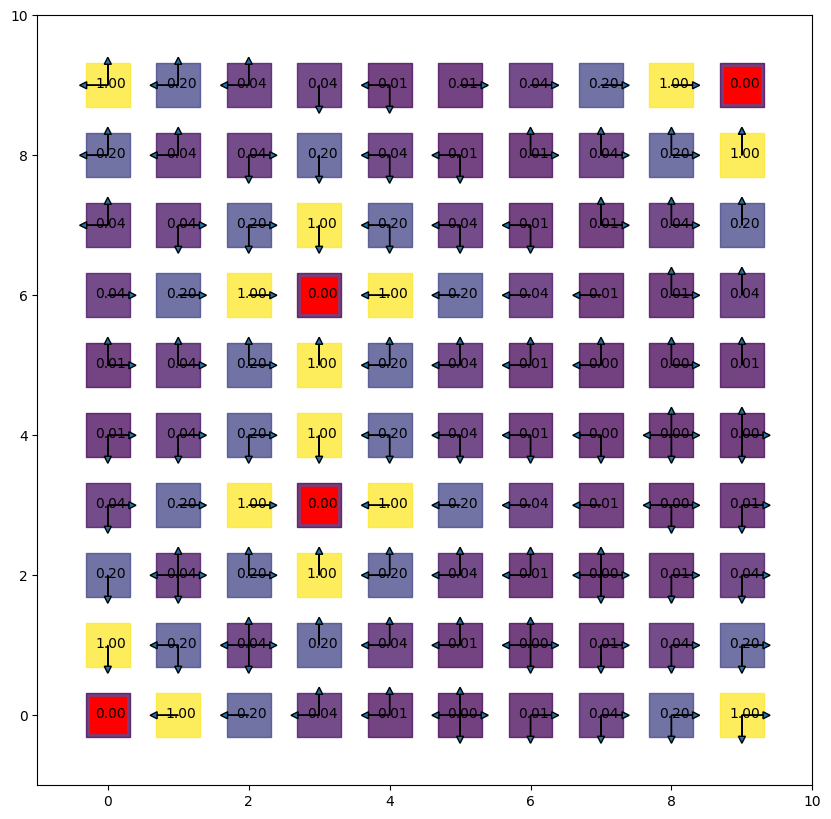

In [6]:
# Test Value Iteration with bigger grid world and multiple terminal states
world_size = 10

# random set some terminal states
terminal_states = []
for i in range(4):
    y, x = np.random.randint(0, world_size, 2)
    terminal_states.append((y, x))

grid_world_2 = GridWorld(world_size, terminal_states=terminal_states)

valueIteration(grid_world_2, figsize=(10, 10))


## 